## Data Preparation

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit


In [3]:
import os
data_path = os.path.join("..","Data","Google_Stock_Price.csv")

In [4]:
# Load data
df = pd.read_csv(data_path)
df.head()

,symbol,date,open,high,low,close,volume,adjclose,dividends,splits
0,GOOG,2018-01-02,52.417000,53.347000,52.261501,53.250000,24752000,53.059353,0.0,0.0
1,GOOG,2018-01-03,53.215500,54.314499,53.160500,54.124001,28604000,53.930225,0.0,0.0
2,GOOG,2018-01-04,54.400002,54.678501,54.200100,54.320000,20092000,54.125519,0.0,0.0
3,GOOG,2018-01-05,54.700001,55.212502,54.599998,55.111500,25582000,54.914188,0.0,0.0
4,GOOG,2018-01-08,55.111500,55.563499,55.081001,55.347000,20952000,55.148846,0.0,0.0


In [5]:
df.columns

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'adjclose',
       'dividends', 'splits'],
      dtype='object')

In [6]:
df.drop('symbol', axis=1, inplace=True)
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'adjclose',
       'dividends', 'splits'],
      dtype='object')

In [7]:
print("\nDataset info:")
df.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1761 non-null   object 
 1   open       1761 non-null   float64
 2   high       1761 non-null   float64
 3   low        1761 non-null   float64
 4   close      1761 non-null   float64
 5   volume     1761 non-null   int64  
 6   adjclose   1761 non-null   float64
 7   dividends  1761 non-null   float64
 8   splits     1761 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 123.9+ KB


In [8]:
# Convert 'date' to datetime and set as index
df['date'] = pd.to_datetime(df['date'])

In [9]:
print("\nStatistical summary:")
df.describe()


Statistical summary:


,date,open,high,low,close,volume,adjclose,dividends,splits
count,1761,1761.000000,1761.000000,1761.000000,1761.000000,1.761000e+03,1761.000000,1761.000000,1761.000000
mean,2021-07-01 15:36:17.172061440,102.021411,103.171589,100.982265,102.092157,2.859376e+07,101.754831,0.000341,0.011357
min,2018-01-02 00:00:00,48.695000,50.176998,48.505501,48.811001,6.809800e+06,48.636250,0.000000,0.000000
25%,2019-10-02 00:00:00,61.463001,62.043999,60.938499,61.496498,1.992200e+07,61.276325,0.000000,0.000000
50%,2021-07-01 00:00:00,100.059998,101.658997,99.169998,100.739998,2.561200e+07,100.379326,0.000000,0.000000
75%,2023-03-31 00:00:00,135.570007,137.070999,134.183502,135.990005,3.304600e+07,135.503128,0.000000,0.000000
max,2024-12-31 00:00:00,198.529999,202.880005,196.690002,198.160004,1.241400e+08,198.160004,0.200000,20.000000
std,NaN,39.637483,40.020994,39.274690,39.637305,1.317064e+07,39.547744,0.008250,0.476596


In [10]:
print("\nMissing values in each column:")
df.isnull().sum()


Missing values in each column:


date         0
open         0
high         0
low          0
close        0
volume       0
adjclose     0
dividends    0
splits       0
dtype: int64

## Exploratory Data Analysis

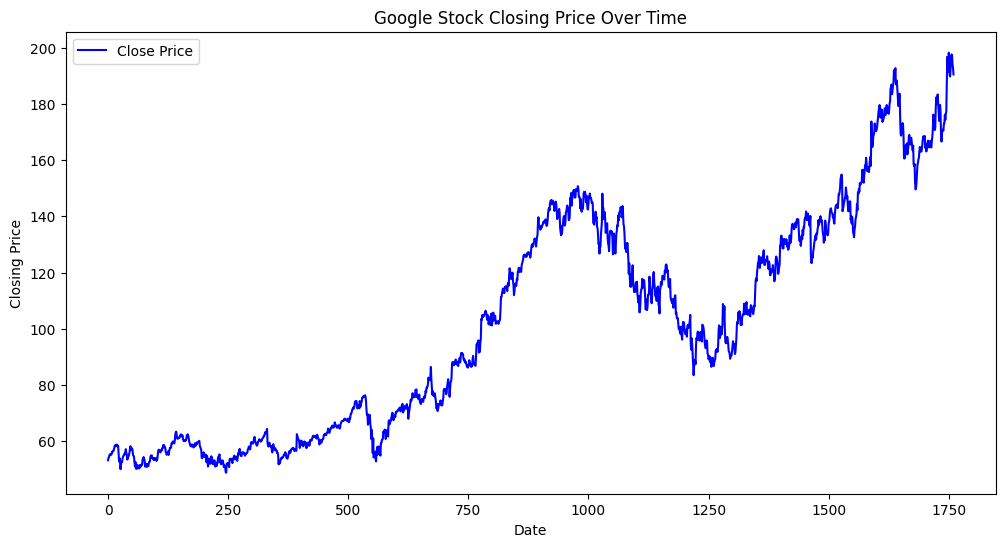

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.title('Google Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

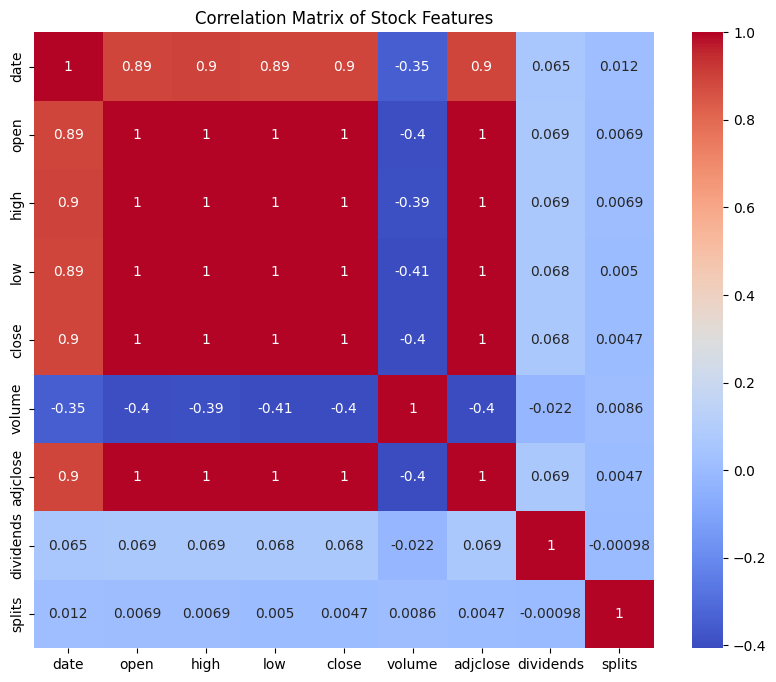

In [12]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Stock Features')
plt.show()

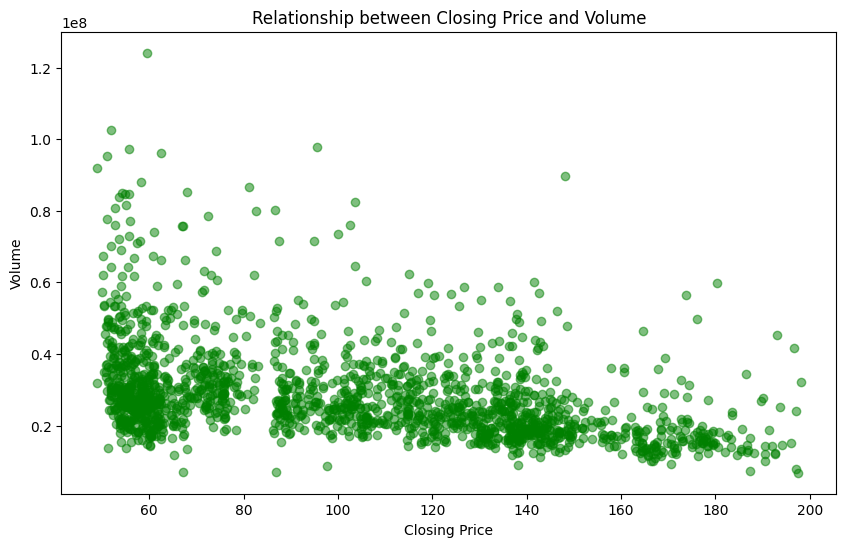

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(df['close'], df['volume'], alpha=0.5, color='green')
plt.title('Relationship between Closing Price and Volume')
plt.xlabel('Closing Price')
plt.ylabel('Volume')
plt.show()

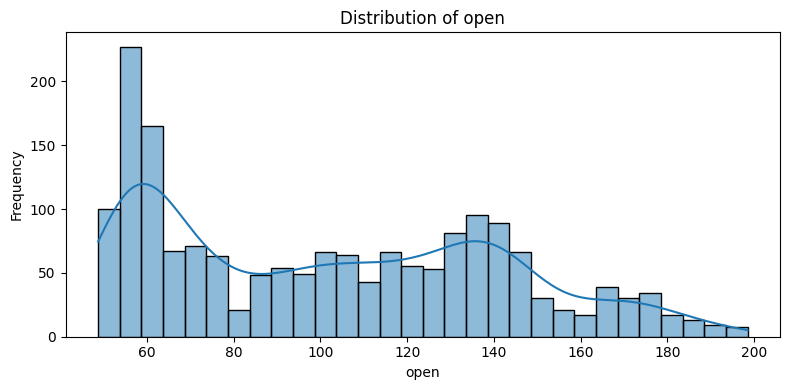

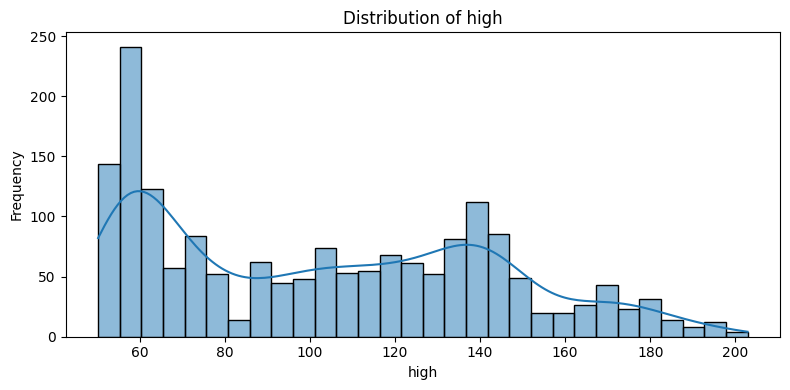

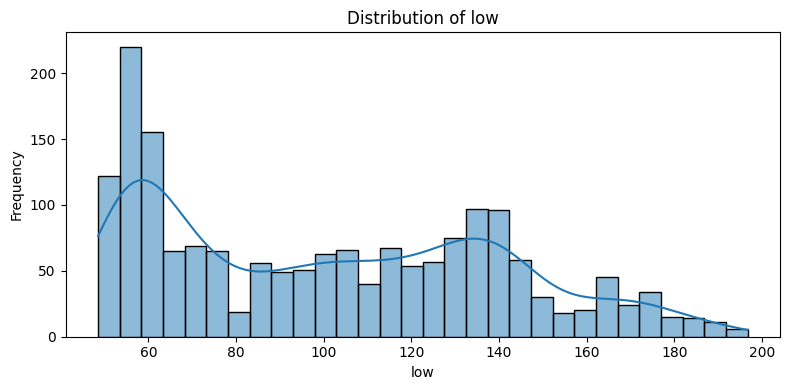

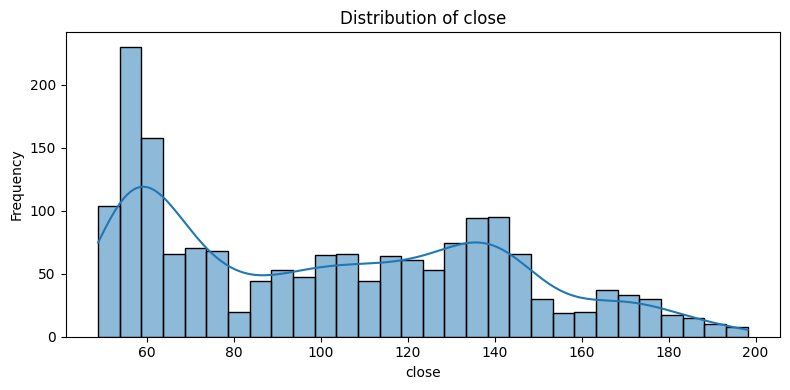

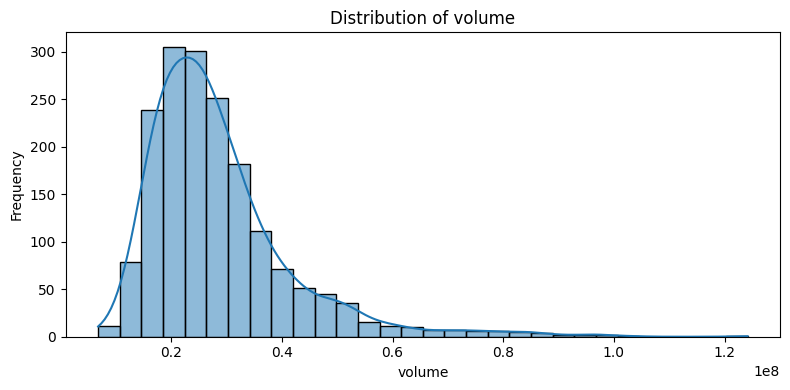

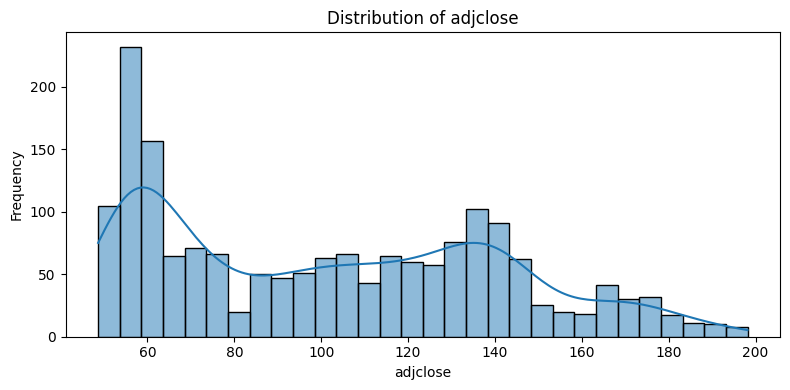

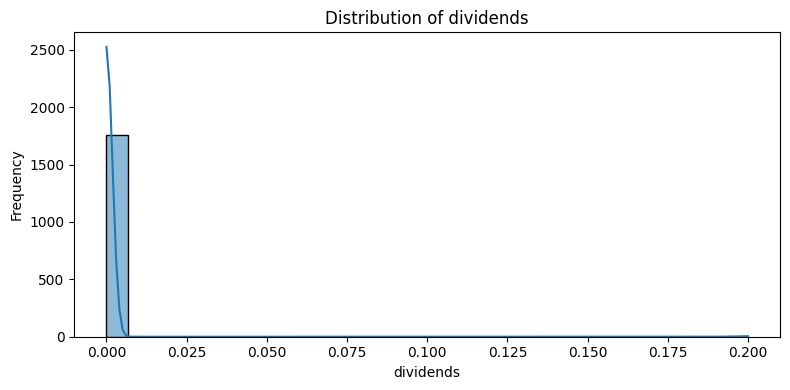

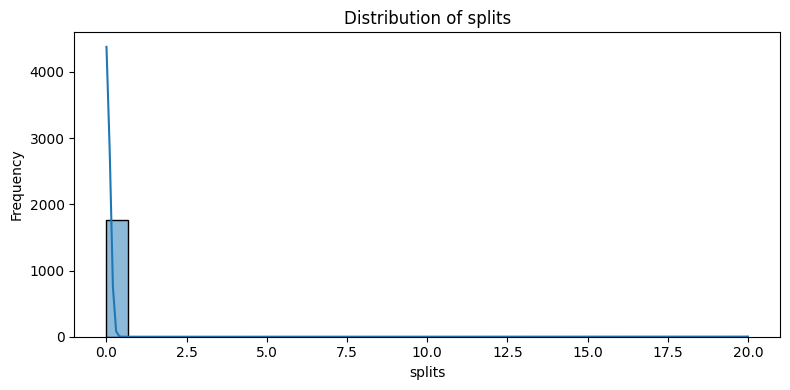

In [14]:
# Plot histograms for numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

## Modeling Approaches

In [15]:
googl = df.copy()
googl.head()

,date,open,high,low,close,volume,adjclose,dividends,splits
0,2018-01-02,52.417000,53.347000,52.261501,53.250000,24752000,53.059353,0.0,0.0
1,2018-01-03,53.215500,54.314499,53.160500,54.124001,28604000,53.930225,0.0,0.0
2,2018-01-04,54.400002,54.678501,54.200100,54.320000,20092000,54.125519,0.0,0.0
3,2018-01-05,54.700001,55.212502,54.599998,55.111500,25582000,54.914188,0.0,0.0
4,2018-01-08,55.111500,55.563499,55.081001,55.347000,20952000,55.148846,0.0,0.0


In [16]:
# Convert 'date' to datetime and set as index
googl['date'] = pd.to_datetime(googl['date'])
googl = googl.set_index('date').sort_index()

In [17]:
# Create target variable - next day's closing price
googl['target'] = googl['close'].shift(-1)
googl = googl.dropna()

In [18]:
# Train-test split (80/20)
split_date = googl.index[int(len(googl) * 0.8)]
train = googl.loc[googl.index < split_date]
test = googl.loc[googl.index >= split_date]

print("Data loaded and processed successfully.")
print(f"Train set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
googl.head()

Data loaded and processed successfully.
Train set shape: (1408, 9)
Test set shape: (352, 9)


,open,high,low,close,volume,adjclose,dividends,splits,target
date,,,,,,,,,
2018-01-02,52.417000,53.347000,52.261501,53.250000,24752000,53.059353,0.0,0.0,54.124001
2018-01-03,53.215500,54.314499,53.160500,54.124001,28604000,53.930225,0.0,0.0,54.320000
2018-01-04,54.400002,54.678501,54.200100,54.320000,20092000,54.125519,0.0,0.0,55.111500
2018-01-05,54.700001,55.212502,54.599998,55.111500,25582000,54.914188,0.0,0.0,55.347000
2018-01-08,55.111500,55.563499,55.081001,55.347000,20952000,55.148846,0.0,0.0,55.313000


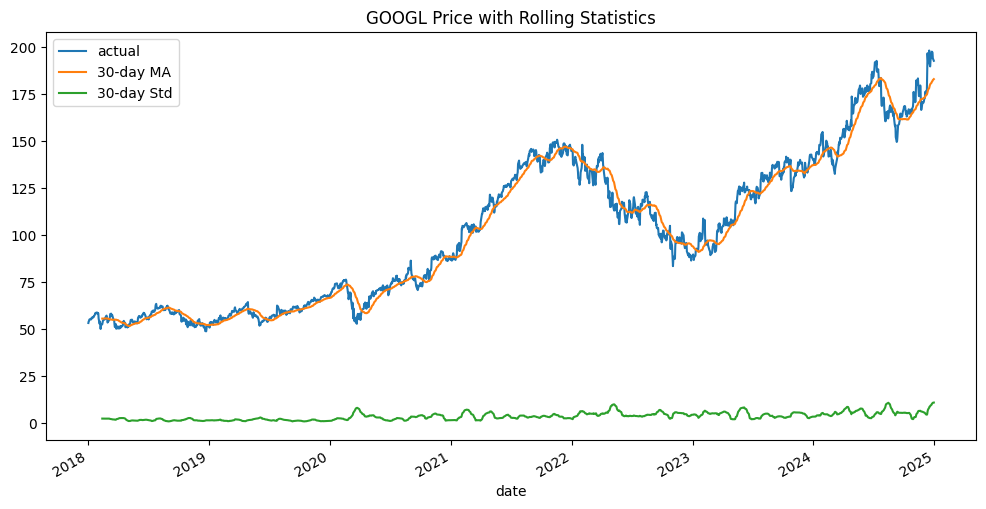

In [19]:
# Rolling statistics
rolling_window = 30
plt.figure(figsize=(12,6))
googl['close'].plot(label='actual')
googl['close'].rolling(rolling_window).mean().plot(label=f'{rolling_window}-day MA')
googl['close'].rolling(rolling_window).std().plot(label=f'{rolling_window}-day Std')
plt.legend()
plt.title('GOOGL Price with Rolling Statistics')
plt.show()

In [21]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# Stationarity tests
def test_stationarity(series):
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')
    
    # KPSS Test
    kpss_result = kpss(series, regression='c')
    print(f'\nKPSS Statistic: {kpss_result[0]}')
    print(f'p-value: {kpss_result[1]}')
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value}')

test_stationarity(googl['close'])

ADF Statistic: 0.028716619509879547
p-value: 0.9608434733246429
Critical Values:
	1%: -3.4340794333632534
	5%: -2.863187337213453
	10%: -2.567646992971705

KPSS Statistic: 5.388326689366503
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\allen_vvyeprk\AppData\Local\Temp\ipykernel_6004\2053180701.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c')


In [22]:
def make_stationary(data, column='Close', diff_order=1, log_transform=False):
    """
    Transform time series data to stationary using differencing and/or log transform
    
    Parameters:
    - data: DataFrame containing the time series
    - column: Name of column to transform
    - diff_order: Order of differencing (1 for first differences, etc.)
    - log_transform: Whether to apply log transformation first
    
    Returns:
    - Transformed DataFrame with new columns and NaN rows dropped
    """
    df = data.copy()
    
    # Apply log transform if requested (helps with multiplicative effects)
    if log_transform:
        df[f'log_{column}'] = np.log(df[column])
        transform_col = f'log_{column}'
    else:
        transform_col = column
    
    # Apply differencing
    for i in range(1, diff_order+1):
        df[f'{transform_col}_diff_{i}'] = df[transform_col].diff()
    
    # Drop rows with NaN values created by differencing
    df = df.dropna()
    
    return df

In [23]:
# Apply transformation to entire dataset
googl_stationary = make_stationary(googl, column='close', diff_order=1, log_transform=True)

# Apply the same transformation to train and test sets separately
# Important to prevent data leakage - each set must be transformed independently
train_stationary = make_stationary(train, column='close', diff_order=1, log_transform=True)
test_stationary = make_stationary(test, column='close', diff_order=1, log_transform=True)

In [24]:
# Show results
print("\nData Head after Transformation:")
print(googl_stationary[['close', 'log_close', 'log_close_diff_1']].head())

# Test stationarity
print("\nStationarity Test Results for Transformed Data:")
test_stationarity(googl_stationary['log_close_diff_1'])

print("\nStationarity Test Results for Original Data:")
test_stationarity(googl['close'])


Data Head after Transformation:
                close  log_close  log_close_diff_1
date                                              
2018-01-03  54.124001   3.991278          0.016280
2018-01-04  54.320000   3.994892          0.003615
2018-01-05  55.111500   4.009358          0.014466
2018-01-08  55.347000   4.013622          0.004264
2018-01-09  55.313000   4.013008         -0.000615

Stationarity Test Results for Transformed Data:
ADF Statistic: -13.961219836892175
p-value: 4.516300863602311e-26
Critical Values:
	1%: -3.4340922388213175
	5%: -2.863192990001633
	10%: -2.5676500029387754

KPSS Statistic: 0.0608142154355465
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

Stationarity Test Results for Original Data:
ADF Statistic: 0.028716619509879547
p-value: 0.9608434733246429
Critical Values:
	1%: -3.4340794333632534
	5%: -2.863187337213453
	10%: -2.567646992971705

KPSS Statistic: 5.388326689366503
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463


C:\Users\allen_vvyeprk\AppData\Local\Temp\ipykernel_6004\2053180701.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
C:\Users\allen_vvyeprk\AppData\Local\Temp\ipykernel_6004\2053180701.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c')


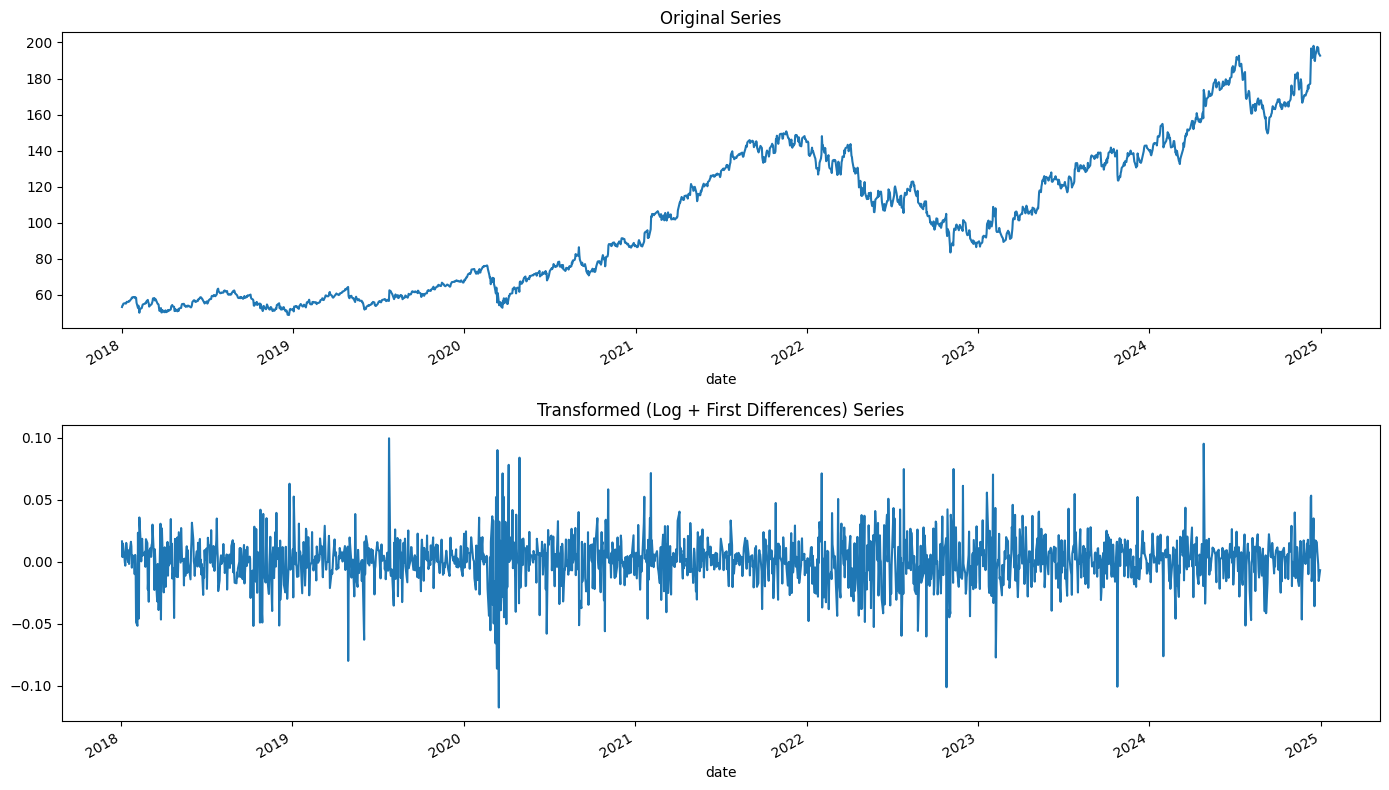

In [25]:
# Visual comparison
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
googl['close'].plot(title='Original Series')
plt.subplot(2, 1, 2)
googl_stationary['log_close_diff_1'].plot(title='Transformed (Log + First Differences) Series')
plt.tight_layout()
plt.show()

In [66]:
# First ensure consistent lengths
def create_baselines(df):
    """Create baseline predictions ensuring consistent lengths"""
    df = df.copy()
    
    # Create target (next period's diff)
    df['target_diff'] = df['log_close_diff_1'].shift(-1)
    
    # Naive forecast (last observed diff)
    df['naive_pred'] = df['log_close_diff_1'].shift(1)
    
    # SMA forecast
    sma_window = 30
    df['sma_pred'] = df['log_close_diff_1'].rolling(sma_window).mean().shift(1)
    
    # Drop rows with any NA values (from shifts/rolling)
    df = df.dropna()
    
    return df

In [27]:
# Apply to test set
test_baselines = create_baselines(test_stationary)

## Baseline Model

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [29]:
# Evaluation function
def evaluate_diff_metrics(y_true, y_pred, original_series=None):
    # First ensure equal lengths
    y_true, y_pred = y_true.align(y_pred, join='inner')
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f'MAE: {mae:.6f}')  # More decimals for small differenced values
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}')
    
    # Convert back to original scale if original series provided
    if original_series is not None:
        last_known_price = original_series.loc[:test_baselines.index[0]].iloc[-1]
        
        # Reconstruct prices from log-differences
        pred_prices = np.exp(np.log(last_known_price) + y_pred.cumsum())
        true_prices = original_series.loc[test_baselines.index]
        
        mae_original = mean_absolute_error(true_prices, pred_prices)
        print(f'\nMAE on original scale: ${mae_original:.2f}')
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

### Naive & Simple Moving Average

In [30]:
# Evaluate
print("Naive Forecast:")
naive_metrics = evaluate_diff_metrics(test_baselines['target_diff'], 
                                    test_baselines['naive_pred'],
                                    original_series=googl['close'])

print("\nSMA Forecast:")
sma_metrics = evaluate_diff_metrics(test_baselines['target_diff'], 
                                  test_baselines['sma_pred'],
                                  original_series=googl['close'])

Naive Forecast:
MAE: 0.018460
MSE: 0.000662
RMSE: 0.025736

MAE on original scale: $8.76

SMA Forecast:
MAE: 0.012648
MSE: 0.000320
RMSE: 0.017877

MAE on original scale: $7.84


## Statistical Model
### ARIMA/SARIMA

In [31]:
!pip install pmdarima

In [32]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [42]:
# Use the transformed training data (log-differenced)
auto_model = auto_arima(train_stationary['log_close_diff_1'], 
                        seasonal=False, 
                        trace=True,
                        error_action='ignore', 
                        suppress_warnings=True,
                        stepwise=True, 
                        information_criterion='aic',
                        stationary=True)  # We already differenced the data

print(auto_model.summary())

e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7031.905, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7029.507, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7037.587, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7037.841, Time=0.05 sec


e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7030.027, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7036.031, Time=0.18 sec


e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-7035.981, Time=0.17 sec


e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7034.818, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7038.070, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7036.208, Time=0.09 sec


e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-7036.176, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7037.848, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7034.543, Time=0.11 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.459 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1407
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3521.035
Date:                Tue, 20 May 2025   AIC                          -7038.070
Time:                        14:57:41   BIC                          -7027.572
Sample:                             0   HQIC                         -7034.147
                               - 1407                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\TimeSeries\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [43]:
# Fit ARIMA with optimal parameters (note d=0 since we pre-differenced)
arima_order = auto_model.order
arima_model = ARIMA(train_stationary['log_close_diff_1'], 
                   order=arima_order)
arima_fit = arima_model.fit()

e:\TimeSeries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\TimeSeries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\TimeSeries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
# Forecast differences
arima_pred_diff = arima_fit.forecast(steps=len(test_stationary))

e:\TimeSeries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\TimeSeries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [45]:
# Reconstruct the actual price predictions
def inverse_transform(last_known_price, log_diff_predictions):
    """
    Convert log-differenced predictions back to original price scale
    last_known_price: scalar - the last price before forecast period
    log_diff_predictions: array-like - predicted log differences
    """
    log_prices = np.log(last_known_price) + np.cumsum(log_diff_predictions)
    return np.exp(log_prices)

In [46]:
def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

In [47]:
# Get the last known price before test period
last_train_price = train['close'].iloc[-1]

# Reconstruct test prices
arima_pred_prices = inverse_transform(last_train_price, arima_pred_diff)

# Align with actual test prices
test_true_prices = test['close'].iloc[:len(arima_pred_prices)]

# Evaluate
arima_metrics = evaluate_metrics(test_true_prices, arima_pred_prices)

MAE: 10.81
MSE: 217.74
RMSE: 14.76
MAPE: nan%


C:\Users\allen_vvyeprk\AppData\Local\Temp\ipykernel_6004\1392839.py:5: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


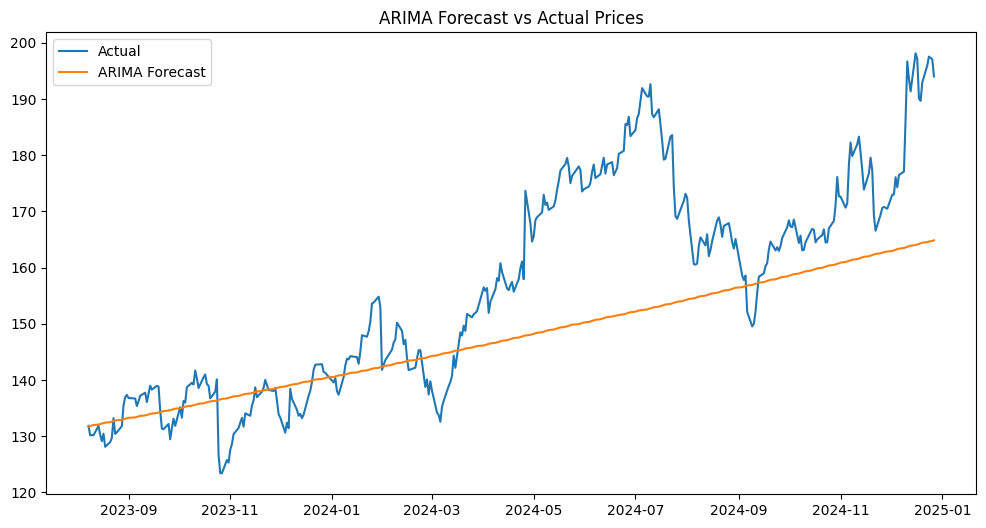

In [48]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_true_prices.index, test_true_prices, label='Actual')
plt.plot(test_true_prices.index, arima_pred_prices, label='ARIMA Forecast')
plt.title('ARIMA Forecast vs Actual Prices')
plt.legend()
plt.show()

## Machine Learning Models

### Feature Engineering

In [49]:
# Enhanced feature creation with proper type handling
def create_features(df, lags=5):
    df = df.copy()
    
    # Ensure we only work with numeric columns
    if 'symbol' in df.columns:
        df = df.drop('symbol', axis=1)
    
    # Lag features
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['close'].shift(lag)
    
    # Rolling statistics
    df['rolling_mean'] = df['close'].rolling(window=5).mean().shift(1)
    df['rolling_std'] = df['close'].rolling(window=5).std().shift(1)
    
    # Volatility features
    df['returns'] = df['close'].pct_change()
    df['volatility'] = df['returns'].rolling(window=5).std().shift(1)
    
    # Date features (convert to proper numeric types)
    df['day_of_week'] = df.index.dayofweek.astype('int8')
    df['month'] = df.index.month.astype('int8')
    df['quarter'] = df.index.quarter.astype('int8')
    
    # Additional useful features
    df['high_low_spread'] = (df['high'] - df['low'])/df['close']
    df['close_open_spread'] = (df['close'] - df['open'])/df['open']
    
    return df.dropna()

# Create features
train_feats = create_features(train)
test_feats = create_features(test)

# Verify all columns are numeric
print("Feature dtypes:")
print(train_feats.dtypes)

# Prepare X and y
X_train = train_feats.drop(['target', 'close'], axis=1, errors='ignore')
y_train = train_feats['target']
X_test = test_feats.drop(['target', 'close'], axis=1, errors='ignore')
y_test = test_feats['target']

# Convert to float32 for better performance with XGBoost
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Feature dtypes:
open                 float64
high                 float64
low                  float64
close                float64
volume                 int64
adjclose             float64
dividends            float64
splits               float64
target               float64
lag_1                float64
lag_2                float64
lag_3                float64
lag_4                float64
lag_5                float64
rolling_mean         float64
rolling_std          float64
returns              float64
volatility           float64
day_of_week             int8
month                   int8
quarter                 int8
high_low_spread      float64
close_open_spread    float64
dtype: object


In [51]:
# Configure XGBoost with better time-series settings
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,  # Larger number with early stopping
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
scores = []

for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    xgb_model.fit(
        X_train_cv, y_train_cv,
        eval_set=[(X_val_cv, y_val_cv)],
        verbose=50  # Shows progress every 50 trees
    )
    
    preds = xgb_model.predict(X_val_cv)
    score = mean_absolute_error(y_val_cv, preds)
    scores.append(score)
    print(f'Fold MAE: {score:.4f}')

print(f'\nAverage MAE across folds: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

[0]	validation_0-rmse:4.36833
[50]	validation_0-rmse:3.07693
[100]	validation_0-rmse:2.34309
[150]	validation_0-rmse:1.94778
[200]	validation_0-rmse:1.74984
[250]	validation_0-rmse:1.63960
[300]	validation_0-rmse:1.57569
[350]	validation_0-rmse:1.53142
[400]	validation_0-rmse:1.50906
[450]	validation_0-rmse:1.49691
[500]	validation_0-rmse:1.48820
[550]	validation_0-rmse:1.48329
[600]	validation_0-rmse:1.48114
[650]	validation_0-rmse:1.47945
[678]	validation_0-rmse:1.48005
Fold MAE: 0.9967
[0]	validation_0-rmse:14.97582
[50]	validation_0-rmse:12.57597
[100]	validation_0-rmse:11.45417
[150]	validation_0-rmse:10.60031
[200]	validation_0-rmse:9.97244
[250]	validation_0-rmse:9.57826
[300]	validation_0-rmse:9.28725
[350]	validation_0-rmse:9.10678
[400]	validation_0-rmse:8.95263
[450]	validation_0-rmse:8.85342
[500]	validation_0-rmse:8.81390
[550]	validation_0-rmse:8.77621
[600]	validation_0-rmse:8.75007
[650]	validation_0-rmse:8.74058
[700]	validation_0-rmse:8.73293
[750]	validation_0-rmse:8

In [52]:
# Final model training
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

# Predictions and evaluation
xgb_pred = xgb_model.predict(X_test)
xgb_metrics = evaluate_metrics(y_test, xgb_pred)

[0]	validation_0-rmse:30.38176	validation_1-rmse:70.53229
[50]	validation_0-rmse:18.57199	validation_1-rmse:51.06531
[100]	validation_0-rmse:11.40036	validation_1-rmse:39.06174
[150]	validation_0-rmse:7.07033	validation_1-rmse:31.91718
[200]	validation_0-rmse:4.47332	validation_1-rmse:27.66905
[250]	validation_0-rmse:2.94225	validation_1-rmse:25.11780
[300]	validation_0-rmse:2.05726	validation_1-rmse:23.52481
[350]	validation_0-rmse:1.55166	validation_1-rmse:22.56415
[400]	validation_0-rmse:1.27182	validation_1-rmse:21.95472
[450]	validation_0-rmse:1.10733	validation_1-rmse:21.51811
[500]	validation_0-rmse:1.00525	validation_1-rmse:21.23022
[550]	validation_0-rmse:0.93675	validation_1-rmse:21.00860
[600]	validation_0-rmse:0.88069	validation_1-rmse:20.90536
[650]	validation_0-rmse:0.83441	validation_1-rmse:20.83389
[700]	validation_0-rmse:0.79886	validation_1-rmse:20.77564
[750]	validation_0-rmse:0.76612	validation_1-rmse:20.74483
[800]	validation_0-rmse:0.73586	validation_1-rmse:20.724

<Figure size 1200x800 with 0 Axes>

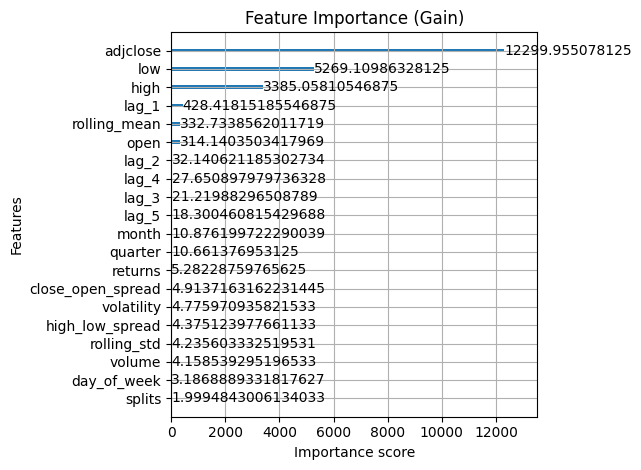

In [53]:
# Feature importance with better visualization
plt.figure(figsize=(12, 8))
xgb.plot_importance(
    xgb_model, 
    max_num_features=20,
    importance_type='gain',
    title='Feature Importance (Gain)'
)
plt.tight_layout()
plt.show()

In [54]:
# Compare all models
metrics_df = pd.DataFrame({
    'Naive': naive_metrics,
    'SMA': sma_metrics,
    'ARIMA': arima_metrics,
    'XGBoost': xgb_metrics,
}).T

print(metrics_df.sort_values('RMSE'))

               MAE         MSE       RMSE      MAPE
SMA       0.012648    0.000320   0.017877       NaN
Naive     0.018460    0.000662   0.025736       NaN
ARIMA    10.806780  217.743815  14.756145       NaN
XGBoost  15.172163  428.291454  20.695204  8.780186


## LSTM Deep Learning Model

### Normalizing Target

In [33]:
close_data = df[['close']].values

scaler = MinMaxScaler(feature_range=(0, 1))
close_data_norm = scaler.fit_transform(close_data)

### Creating LSTM

In [34]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(close_data_norm, seq_length)

train_size = int(len(X) * 0.8)    # Split into training and testing sets (80% train, 20% test)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Simple 1 LSTM Layer

In [35]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        out, _ = self.lstm(x)
        # Only take the output from the last time step
        out = self.fc(out[:, -1, :])
        return out

### Medium 2 LSTM Layer

In [36]:
class MediumLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=2, dropout=0.2):
        super(MediumLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

### Training Setup

In [37]:
def train_model(model, train_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    
    for epoch in range(num_epochs):
        epoch_losses = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_losses):.6f}")
    return model

In [38]:
simple_model = SimpleLSTM()
print("Training Simple LSTM Model")
simple_model = train_model(simple_model, train_loader, num_epochs=100)

Training Simple LSTM Model
Epoch [1/100], Loss: 0.073844
Epoch [2/100], Loss: 0.027728
Epoch [3/100], Loss: 0.013319
Epoch [4/100], Loss: 0.004245
Epoch [5/100], Loss: 0.002973
Epoch [6/100], Loss: 0.001843
Epoch [7/100], Loss: 0.001358
Epoch [8/100], Loss: 0.000987
Epoch [9/100], Loss: 0.000745
Epoch [10/100], Loss: 0.000603
Epoch [11/100], Loss: 0.000503
Epoch [12/100], Loss: 0.000497
Epoch [13/100], Loss: 0.000512
Epoch [14/100], Loss: 0.000466
Epoch [15/100], Loss: 0.000465
Epoch [16/100], Loss: 0.000482
Epoch [17/100], Loss: 0.000450
Epoch [18/100], Loss: 0.000445
Epoch [19/100], Loss: 0.000448
Epoch [20/100], Loss: 0.000438
Epoch [21/100], Loss: 0.000435
Epoch [22/100], Loss: 0.000417
Epoch [23/100], Loss: 0.000438
Epoch [24/100], Loss: 0.000407
Epoch [25/100], Loss: 0.000404
Epoch [26/100], Loss: 0.000393
Epoch [27/100], Loss: 0.000388
Epoch [28/100], Loss: 0.000393
Epoch [29/100], Loss: 0.000377
Epoch [30/100], Loss: 0.000376
Epoch [31/100], Loss: 0.000388
Epoch [32/100], Loss:

In [39]:
medium_model = MediumLSTM()
print("\nTraining Medium LSTM Model")
medium_model = train_model(medium_model, train_loader, num_epochs=100)


Training Medium LSTM Model
Epoch [1/100], Loss: 0.057493
Epoch [2/100], Loss: 0.018901
Epoch [3/100], Loss: 0.006330
Epoch [4/100], Loss: 0.001847
Epoch [5/100], Loss: 0.001139
Epoch [6/100], Loss: 0.000832
Epoch [7/100], Loss: 0.000730
Epoch [8/100], Loss: 0.000656
Epoch [9/100], Loss: 0.000635
Epoch [10/100], Loss: 0.000587
Epoch [11/100], Loss: 0.000584
Epoch [12/100], Loss: 0.000587
Epoch [13/100], Loss: 0.000595
Epoch [14/100], Loss: 0.000563
Epoch [15/100], Loss: 0.000539
Epoch [16/100], Loss: 0.000546
Epoch [17/100], Loss: 0.000598
Epoch [18/100], Loss: 0.000593
Epoch [19/100], Loss: 0.000612
Epoch [20/100], Loss: 0.000546
Epoch [21/100], Loss: 0.000539
Epoch [22/100], Loss: 0.000498
Epoch [23/100], Loss: 0.000523
Epoch [24/100], Loss: 0.000544
Epoch [25/100], Loss: 0.000509
Epoch [26/100], Loss: 0.000505
Epoch [27/100], Loss: 0.000528
Epoch [28/100], Loss: 0.000499
Epoch [29/100], Loss: 0.000554
Epoch [30/100], Loss: 0.000508
Epoch [31/100], Loss: 0.000515
Epoch [32/100], Loss

In [40]:
def predict(model, X_data):
    model.eval()
    with torch.no_grad():
        predictions = model(X_data).detach().numpy()
    return predictions

pred_simple = predict(simple_model, X_test_tensor)
pred_medium = predict(medium_model, X_test_tensor)

y_test_inv = scaler.inverse_transform(y_test)
pred_simple_inv = scaler.inverse_transform(pred_simple)
pred_medium_inv = scaler.inverse_transform(pred_medium)


test_dates = df['date'].values[-len(y_test):]

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan
    return mae, mse, rmse, mape


In [58]:
# Ensure shapes match for evaluation
y_test_flat = y_test_inv.flatten()
pred_simple_flat = pred_simple_inv.flatten()
pred_medium_flat = pred_medium_inv.flatten()

# Get scores
simple_mae, simple_mse, simple_rmse, simple_mape = evaluate_model(y_test_flat, pred_simple_flat)
medium_mae, medium_mse, medium_rmse, medium_mape = evaluate_model(y_test_flat, pred_medium_flat)


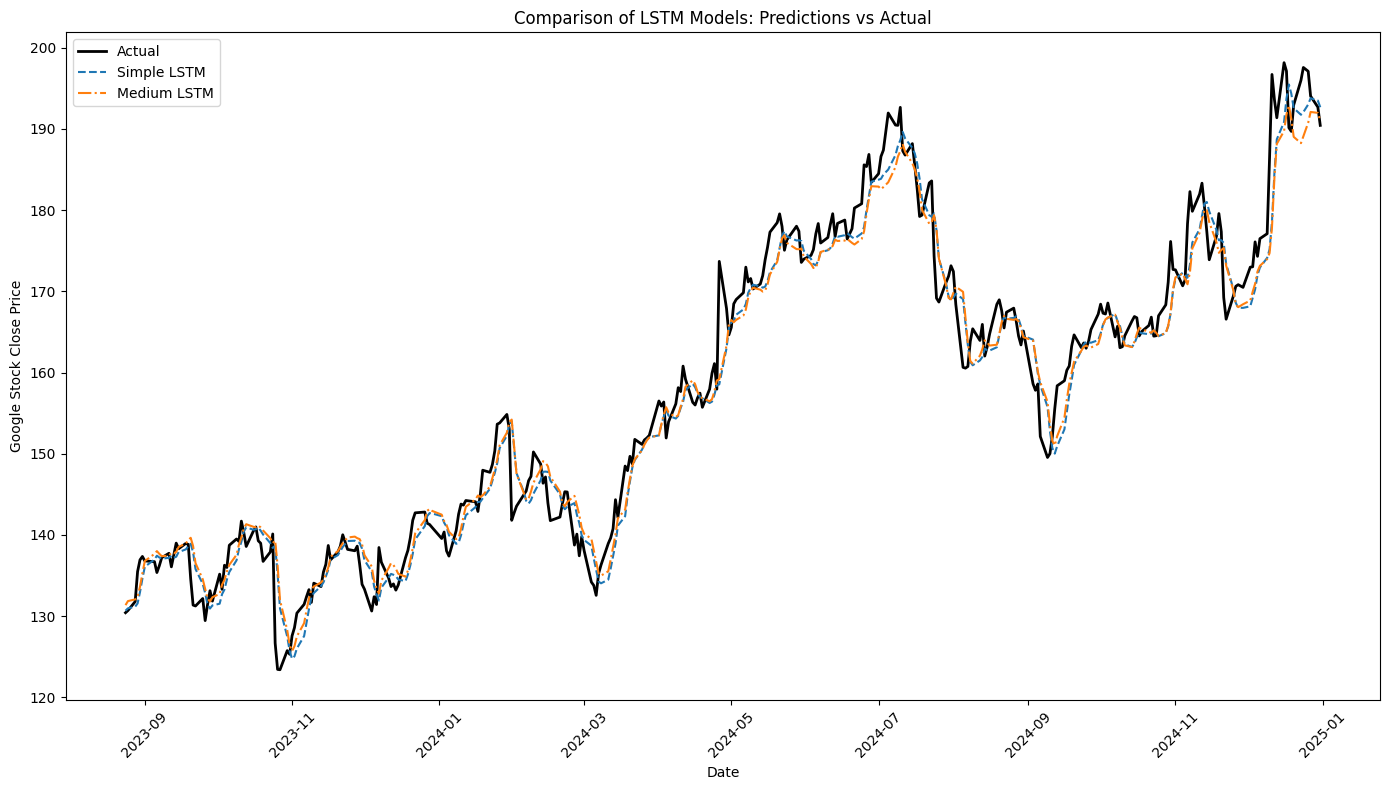

In [41]:
plt.figure(figsize=(14, 8))

plt.plot(test_dates, y_test_inv, label='Actual', color='black', linewidth=2)
plt.plot(test_dates, pred_simple_inv, label='Simple LSTM', linestyle='--')
plt.plot(test_dates, pred_medium_inv, label='Medium LSTM', linestyle='-.')
plt.title("Comparison of LSTM Models: Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Google Stock Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
import pandas as pd

results = {
    "Model": ["SMA", "Naive", "ARIMA", "XGBoost", "SimpleLSTM", "MediumLSTM"],
    "MAE": [0.012648, 0.018460, 10.806780, 15.172163, simple_mae, medium_mae],
    "MSE": [0.000320, 0.000662, 217.743815, 428.291454, simple_mse, medium_mse],
    "RMSE": [0.017877, 0.025736, 14.756145, 20.695204, simple_rmse, medium_rmse],
    "MAPE": [np.nan, np.nan, np.nan, 8.780186, simple_mape, medium_mape]
}

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


     Model       MAE        MSE      RMSE     MAPE
       SMA  0.012648   0.000320  0.017877      NaN
     Naive  0.018460   0.000662  0.025736      NaN
     ARIMA 10.806780 217.743815 14.756145      NaN
   XGBoost 15.172163 428.291454 20.695204 8.780186
SimpleLSTM  2.781183  13.487847  3.672580 1.763194
MediumLSTM  2.816625  14.217653  3.770630 1.777944


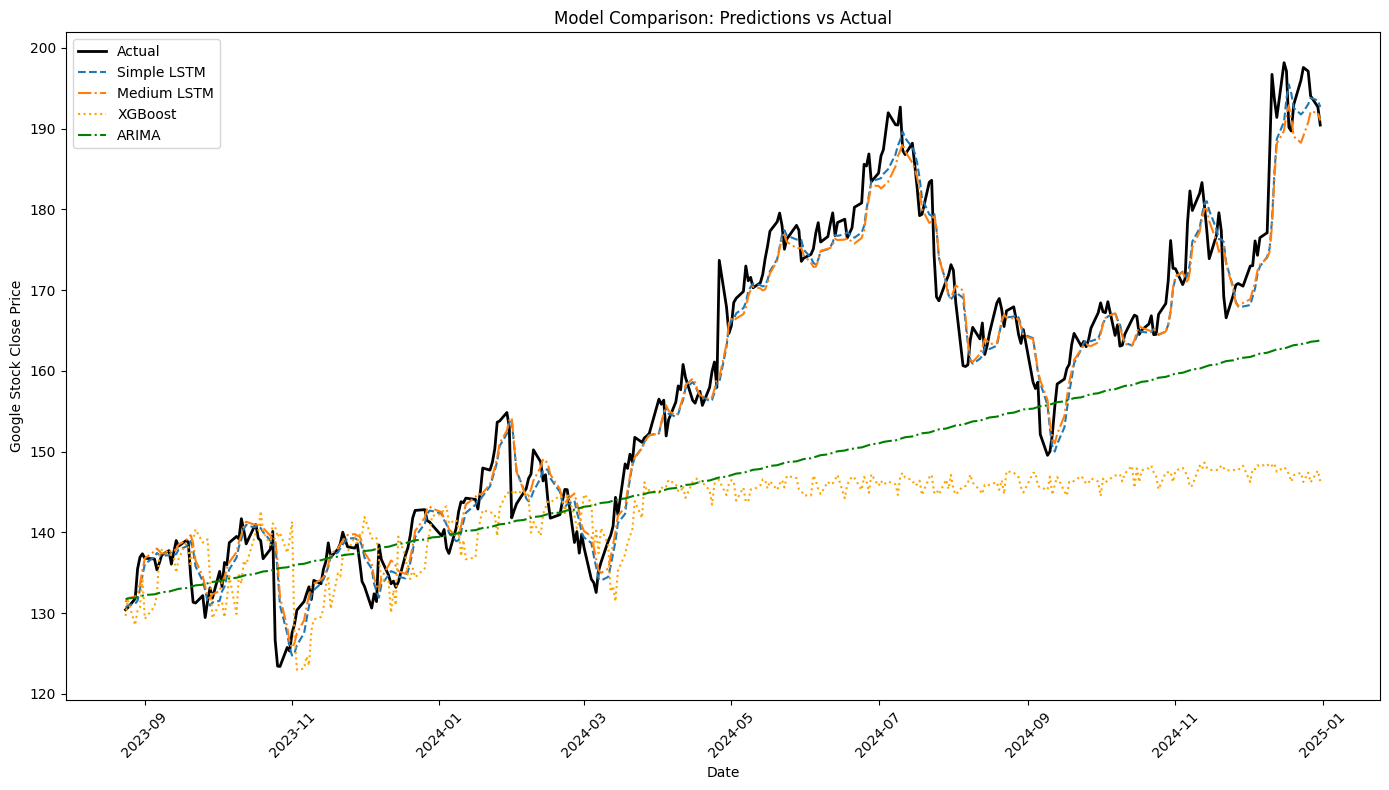

In [64]:
plt.figure(figsize=(14, 8))

plt.plot(test_dates, y_test_inv, label='Actual', color='black', linewidth=2)
plt.plot(test_dates, pred_simple_inv, label='Simple LSTM', linestyle='--')
plt.plot(test_dates, pred_medium_inv, label='Medium LSTM', linestyle='-.')

# Slice predictions to match test_dates length
plt.plot(test_dates, xgb_pred[:341], label='XGBoost', linestyle=':', color='orange')
plt.plot(test_dates, arima_pred_prices[:341], label='ARIMA', linestyle='dashdot', color='green')

plt.title("Model Comparison: Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Google Stock Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
